## We want to evaluate the performance of Label Error Detection of heuristic

In [5]:
import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from scipy.stats import entropy
from collections import Counter
import random

In [1]:
# Load the embeddings and labels
embeddings = torch.load('data/embeddings_512.pt')
labels = torch.load('data/labels_512.pt')

# Converting labels to numpy array for processing
labels = labels.numpy()

def get_label_proportions_and_entropy(neighbors_labels, neighbors_distances):
    label_counts = Counter(neighbors_labels)
    total = sum(label_counts.values(), 0.0)
    label_proportions = {k: v / total for k, v in label_counts.items()}

    # calculate normalized inverse distance for each label
    for label, count in label_counts.items():
        indices = np.where(neighbors_labels == label)[0]
        corresponding_distances = neighbors_distances[indices]
        label_proportions[label] *= np.sum(1 / (1 + corresponding_distances))

    # calculate entropy
    heterogeneity_score = entropy(list(label_proportions.values()))
    
    return label_proportions, heterogeneity_score

# Instantiate the KNeighborsClassifier with k neighbors
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(embeddings, labels)

# Calculate the label proportions and heterogeneity score for each example
label_proportions_list = []
heterogeneity_scores = []
for i, embedding in enumerate(embeddings):
    if i%1000 == 0:
        print(i)
    embedding_numpy = embedding.numpy().reshape(1, -1)
    distances, indices = knn.kneighbors(embedding_numpy)
    neighbors_labels = labels[indices[0]]
    neighbors_distances = distances[0]
    label_proportions, heterogeneity_score = get_label_proportions_and_entropy(neighbors_labels, neighbors_distances)
    label_proportions_list.append(label_proportions)
    heterogeneity_scores.append(heterogeneity_score)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


## Save the calculated scores

In [2]:
# Save the variables to a dictionary
data = {
    'label_proportions_list': label_proportions_list,
    'heterogeneity_scores': heterogeneity_scores
}

# Save the dictionary to a .pt file
torch.save(data, 'dict_label_prop_and_heter_scores.pt')


In [3]:
# Load the saved data from the .pt file
loaded_data = torch.load('dict_label_prop_and_heter_scores.pt')

# Access the loaded variables
loaded_label_proportions_list = loaded_data['label_proportions_list']
loaded_heterogeneity_scores = loaded_data['heterogeneity_scores']

## Control random seed

In [6]:
SEED = 42  # Set your seed value

# Set the random seed for Python's built-in random library
random.seed(SEED)

# Set the random seed for NumPy
np.random.seed(SEED)

# Set the random seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


## Add noise to labels

In [34]:
def add_noise_to_labels(labels, num_classes, noise_rate=0.2):
    # Create identity matrix of size num_classes
    identity_matrix = np.eye(num_classes)
    
    # Create noise matrix of size num_classes x num_classes
    noise_matrix = np.full((num_classes, num_classes), noise_rate / (num_classes - 1))
    
    # Subtract noise_rate from the diagonal elements
    np.fill_diagonal(noise_matrix, 0)
    np.fill_diagonal(noise_matrix, 1 - noise_rate)

    print(f"{noise_matrix = }")
    
    noisy_labels = labels.copy()
    for i, label in enumerate(labels):
        noisy_labels[i] = np.random.choice(num_classes, p=noise_matrix[label])
    
    return noisy_labels


In [35]:
num_classes = len(set(labels))
noisy_labels = add_noise_to_labels(labels, num_classes, noise_rate=0.1)

noise_matrix = array([[0.9       , 0.01111111, 0.01111111, 0.01111111, 0.01111111,
        0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.9       , 0.01111111, 0.01111111, 0.01111111,
        0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.9       , 0.01111111, 0.01111111,
        0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.01111111, 0.9       , 0.01111111,
        0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.9       ,
        0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111,
        0.9       , 0.01111111, 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.01111111,
        0.01111111, 0.9       , 0.01111111, 0.01111111, 0.01111111],
       [0.01111111, 0.0111

In [36]:
print(f"total number of mislabel: {np.sum(labels != noisy_labels)}")

total number of mislabel: 5111


In [37]:
# Calculate mislabeling possibility score for each example
mislabeling_possibility_scores = []
for i, (true_label, noisy_label) in enumerate(zip(labels, noisy_labels)):
    label_proportions = label_proportions_list[i]
    heterogeneity_score = heterogeneity_scores[i]
    PL = label_proportions.get(noisy_label, 0)
    MPS = heterogeneity_score - PL
    mislabeling_possibility_scores.append(MPS)

In [38]:
heterogeneity_scores

[0.0,
 0.7588312516520511,
 0.06484674292089866,
 0.0,
 0.0,
 0.0,
 0.7685260738195483,
 0.0,
 0.06484383931443967,
 0.0,
 0.0,
 0.06487510849273988,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06550685504597265,
 0.22160969064509858,
 0.34672066618302444,
 0.0,
 0.0,
 0.5860383489313656,
 0.0,
 0.6229529764570607,
 0.0,
 0.0,
 0.0,
 0.3665714314443712,
 0.0,
 0.0,
 1.5450375248630068,
 0.0,
 0.0,
 0.0,
 0.06520622565593157,
 0.0,
 0.0,
 0.15463698037769258,
 0.07440431005622733,
 0.5465575217304947,
 0.1548679653487466,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3691753703367907,
 0.7694499567175686,
 0.3478161520874231,
 0.0,
 0.0,
 0.0,
 0.6930142614016741,
 0.0,
 0.6114422460252827,
 1.104673002965277,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.4632769597618083,
 0.0,
 0.0,
 0.1666823195881555,
 1.3106683102274626,
 0.0,
 0.0,
 0.0,
 1.3050816209008664,
 0.0,
 0.4412195634054106,
 0.7671451136494248,
 0.0,
 0.06484552045278634,
 0.7586103408934548,
 0.0,
 0.0649962

In [39]:
label_proportions_list

[{6: 9.012060764659928},
 {9: 2.1649480239553367, 1: 1.3297535461676593, 8: 0.08263128406209147},
 {9: 7.173687201110576, 1: 0.08687139590406519},
 {4: 9.037585061649098},
 {1: 9.244828238454843},
 {1: 8.715046653070239},
 {2: 1.4637380707471803, 5: 0.08842800637638627, 4: 2.2007831114136303},
 {7: 9.353331188483441},
 {8: 7.1662072135060955, 0: 0.08677598613011472},
 {3: 8.823508487257815},
 {4: 9.02599670874815},
 {7: 7.087617623166703, 4: 0.0858757794160287},
 {7: 9.366554907623215},
 {2: 8.615958143762063},
 {9: 9.201598262820472},
 {9: 8.95024804045665},
 {9: 7.236388611726652, 1: 0.08874108012477205},
 {3: 5.664844648204158, 5: 0.34920566303285816},
 {2: 4.130184731080486, 6: 0.08151541697225578, 3: 0.32537973003064785},
 {6: 8.663900601649779},
 {4: 8.911369300134},
 {3: 3.2187695954447157, 5: 0.7802886411997878, 2: 0.08695260552989964},
 {6: 9.183245778484588},
 {6: 1.4665596349309034, 4: 3.1908979256984606},
 {2: 8.782786460472815},
 {6: 8.947526561545535},
 {3: 8.832167020570

In [40]:
mislabeling_possibility_scores

[-9.012060764659928,
 -1.4061167723032857,
 -7.108840458189678,
 -9.037585061649098,
 -9.244828238454843,
 -8.715046653070239,
 -0.695211996927632,
 -9.353331188483441,
 -7.1013633741916555,
 -8.823508487257815,
 -9.02599670874815,
 -7.022742514673963,
 -9.366554907623215,
 -8.615958143762063,
 0.0,
 -8.95024804045665,
 -7.1708817566806795,
 -5.44323495755906,
 -3.783464064897461,
 -8.663900601649779,
 -8.911369300134,
 -2.63273124651335,
 -9.183245778484588,
 -0.8436066584738426,
 -8.782786460472815,
 -8.947526561545535,
 0.0,
 -0.00912113753943461,
 -8.965719499438544,
 -8.783581729342096,
 1.4450375248630067,
 -9.129385857555878,
 -9.053799642639527,
 -8.751376320330813,
 -7.043619438085903,
 -8.420548462865874,
 -8.624505364597578,
 -5.471743760259082,
 -0.025595689943772676,
 0.1715226044365547,
 -5.530901885139083,
 0.0,
 0.0,
 -9.322443851099688,
 -8.955381737912417,
 -9.014957925873798,
 -9.079366613602538,
 -8.431806630500905,
 -8.616434016259573,
 -8.470268327964234,
 0.00033

## Calculate lift for benchmarking

In [41]:
def calculate_lift(scores, true_labels, noisy_labels, T=100):
    num_total_errors = np.sum(true_labels != noisy_labels)
    top_T_indices = np.argsort(scores)[-T:]
    top_T_errors = np.sum(true_labels[top_T_indices] != noisy_labels[top_T_indices])
    lift_at_T = (top_T_errors / T) / (num_total_errors / len(true_labels))
    return lift_at_T


In [42]:
# Calculate lift@100
lift_at_100 = calculate_lift(mislabeling_possibility_scores, labels, noisy_labels, T=100)
print("Lift@100:", lift_at_100)

# Calculate lift@#Error
lift_at_error = calculate_lift(mislabeling_possibility_scores, labels, noisy_labels, T=np.sum(labels != noisy_labels))
print("Lift@#Error:", lift_at_error)

Lift@100: 2.2500489141068285
Lift@#Error: 3.3056021323679468


## Visualize results

In [43]:
# Load the 2D embeddings
embeddings_2d = np.load('data/TSNE_embeddings_2d.npy')

Data Point 26244, True Label: 3, Noisy Label: 3
Data Point 40979, True Label: 8, Noisy Label: 8
Data Point 36921, True Label: 2, Noisy Label: 2
Data Point 41660, True Label: 7, Noisy Label: 7
Data Point 35129, True Label: 1, Noisy Label: 5
Data Point 28357, True Label: 2, Noisy Label: 3
Data Point 5450, True Label: 3, Noisy Label: 3
Data Point 35989, True Label: 5, Noisy Label: 5
Data Point 9900, True Label: 2, Noisy Label: 2
Data Point 14913, True Label: 9, Noisy Label: 9


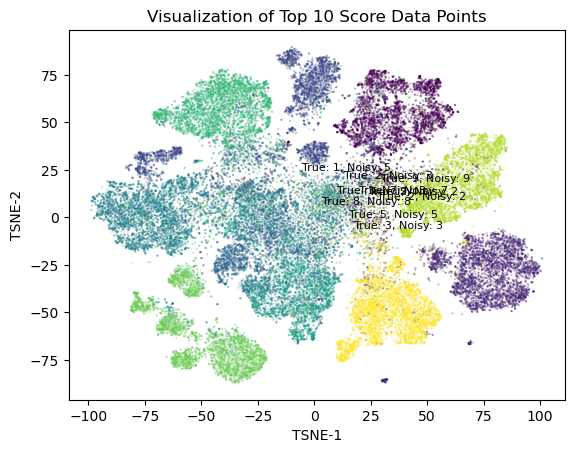

In [44]:
import matplotlib.pyplot as plt

# Get indices of top 10 scores
top_10_indices = np.argsort(mislabeling_possibility_scores)[-10:]

fig, ax = plt.subplots()

# Scatter plot of all points
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, alpha=0.3, s=0.3)

for idx in top_10_indices:
    x, y = embeddings_2d[idx]
    true_label = labels[idx]
    noisy_label = noisy_labels[idx]
    
    # Annotate points with their true and noisy labels
    ax.text(x, y, f'True: {true_label}, Noisy: {noisy_label}', fontsize=8)
    print(f'Data Point {idx}, True Label: {true_label}, Noisy Label: {noisy_label}')

# Set title and labels
ax.set_title('Visualization of Top 10 Score Data Points')
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')

plt.show()


## Print neighborhood informaiton for top scoring data points

In [45]:
def print_neighborhood_info(indices, embeddings, labels, label_proportions_list, heterogeneity_scores):
    # For each index in the top 10
    for index in indices:
        print(f"Neighbors for index {index}:")
        print(f"{mislabeling_possibility_scores[index] = }")
        
        # Use the KNN model to find the k nearest neighbors
        distances, neighbors = knn.kneighbors(embeddings[index].reshape(1, -1))
        neighbors = neighbors[0]

        # Print info for each neighbor
        for i, neighbor in enumerate(neighbors):
            print(f"    Neighbor {i}: index {neighbor}, label {labels[neighbor]}, label proportion {label_proportions_list[neighbor]}, heterogeneity score {heterogeneity_scores[neighbor]}")

# Get the top 10 indices, assuming that indices is your pre-defined list of top 10 indices
print_neighborhood_info(top_10_indices, embeddings, labels, label_proportions_list, heterogeneity_scores)


Neighbors for index 26244:
mislabeling_possibility_scores[index] = 1.7560724494582123
    Neighbor 0: index 26244, label 3, label proportion {3: 0.1, 8: 0.09118680588118733, 5: 0.08946013419026949, 2: 0.3552716572252641, 7: 0.08924269373333683, 4: 0.08829549909352277, 6: 0.35252422639955383, 1: 0.08805936362853864}, heterogeneity score 1.8560724494582124
    Neighbor 1: index 1404, label 8, label proportion {8: 0.1, 3: 0.09118680588118733, 5: 0.09118418312376947, 4: 0.0907438786867962, 6: 0.3594821466391304, 7: 0.08985250565145775, 2: 0.8023465628170559}, heterogeneity score 1.4982782996368829
    Neighbor 2: index 31631, label 5, label proportion {5: 0.3810243955593882, 6: 0.3629484913918726, 8: 0.09118418312376947, 9: 0.08992087142074617, 1: 0.3588314502806374, 4: 0.08971571132211502, 7: 0.0894924409066877}, heterogeneity score 1.7273871337065985
    Neighbor 3: index 31063, label 2, label proportion {2: 0.37826094340963873, 3: 0.08940224581206105, 6: 0.3568190956255016, 7: 0.0891318

## Print neighbor information for mislabels

In [46]:
mislabeled_indices = np.where(noisy_labels != labels)[0]

sample_size = 10  # or any number you want
random_mislabeled_indices = np.random.choice(mislabeled_indices, sample_size, replace=False)

print_neighborhood_info(random_mislabeled_indices, embeddings, noisy_labels, label_proportions_list, heterogeneity_scores)


Neighbors for index 36973:
mislabeling_possibility_scores[index] = 0.0
    Neighbor 0: index 36973, label 5, label proportion {3: 8.909227064668405}, heterogeneity score 0.0
    Neighbor 1: index 48134, label 3, label proportion {3: 9.012786149613072}, heterogeneity score 0.0
    Neighbor 2: index 22425, label 3, label proportion {3: 8.90500528362215}, heterogeneity score 0.0
    Neighbor 3: index 23553, label 3, label proportion {3: 8.89519909854385}, heterogeneity score 0.0
    Neighbor 4: index 39862, label 3, label proportion {3: 7.292719769250432, 5: 0.08827452393609281}, heterogeneity score 0.06482409876878595
    Neighbor 5: index 15826, label 3, label proportion {3: 8.906829176318858}, heterogeneity score 0.0
    Neighbor 6: index 20007, label 3, label proportion {3: 9.011511234386608}, heterogeneity score 0.0
    Neighbor 7: index 2324, label 3, label proportion {3: 8.87064689783703}, heterogeneity score 0.0
    Neighbor 8: index 36036, label 3, label proportion {3: 8.92925717